# Handwritten Digit Recognition with LeNet ,  with CNN analyst of LeNet

This tutorial guides you through the mnist recognition with LeNet, and then analyze the structure of LeNet with the Python API of MXNet. 

The starting part of this notebook is similar to the mnist.ipynb notebook: downlading data, constructing LeNet symbol, training the model.

After that, we will start to analyst the structure of LeNet.

## Load data

We first fetch the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which is a commonly used dataset for handwritten digit recognition. Each image in this dataset has been resized into 28x28 with grayscale value between 0 and 254. The following codes download and load the images and the according labels into `numpy`.

In [1]:
import numpy as np
import os
import urllib
import gzip
import struct
def download_data(url, force_download=False): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.urlretrieve(url, fname)
    return fname

def read_data(label_url, image_url):
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

path='http://yann.lecun.com/exdb/mnist/'
(train_lbl, train_img) = read_data(
    path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data(
    path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

### modifying all the labels to 1, as we are going to run unsupersized learning

In [2]:
for i in range(len(train_lbl)):
    train_lbl[i]=1

train_lbl


array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

In [3]:
for i in range(len(val_lbl)):
    val_lbl[i]=1

val_lbl


array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

We plot the first 10 images and print their labels. 

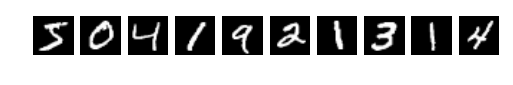

label: [1 1 1 1 1 1 1 1 1 1]


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (train_lbl[0:10],))

Next we create data iterators for MXNet. The data iterator, which is similar the iterator, returns a batch of data in each `next()` call. A batch contains several images with its according labels. These images are stored in a 4-D matrix with shape `(batch_size, num_channels, width, height)`. For the MNIST dataset, there is only one color channel, and both width and height are 28. In addition, we often shuffle the images used for training, which accelerates the training progress.

In [5]:
import mxnet as mx

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 100
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)

## Convolutional Neural Networks

Note that the fully-connected layer in minst.ipynb simply reshapes the image into a vector during training. It ignores the spatial information that pixels are correlated on both horizontal and vertical dimensions. The convolutional layer aims to improve this drawback by using a more structural weight $W$. Instead of simply matrix-matrix multiplication, it uses 2-D convolution to obtain the output. 

<img src="https://thatindiandude.github.io/images/conv.png" style="height: 75%; width: 75%;">

We can also have multiple feature maps, each with their own weight matrices, to capture different features: 
<img src="https://thatindiandude.github.io/images/filters.png" style="height: 75%; width: 75%;">

Besides the convolutional layer, another major change of the convolutional neural network is the adding of pooling layers. A pooling layer reduce a $n\times m$ (often called kernal size) image patch into a single value to make the network less sensitive to the spatial location.

<img src="https://thatindiandude.github.io/images/pooling.png" style="height: 75%; width: 75%;">

In [6]:
data = mx.symbol.Variable('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)
tanh4 = mx.sym.Activation(data=fc2, act_type="tanh")

# new full connect layer to connect 10 output to 2
fc3 = mx.sym.FullyConnected(data=tanh4, num_hidden=2)

# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

Before training the model, you can display the architecuter of LeNet.

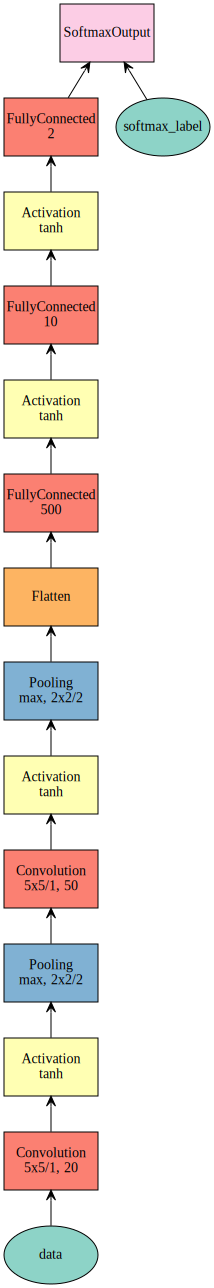

In [7]:
mx.viz.plot_network(lenet)

Note that LeNet is more complex than multilayer perceptron, so we use GPU instead of CPU for training. 

In [8]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

# Output may vary
model = mx.model.FeedForward(
    ctx = mx.gpu(0),     # use GPU 0 for training, others are same as before
    symbol = lenet,       
    num_epoch = 10,     
    learning_rate = 0.1)
model.fit(
    X=train_iter,  
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 200)
) 
assert model.score(val_iter) > 0.98, "Low validation accuracy."

INFO:root:Start training with [gpu(0)]
INFO:root:Epoch[0] Batch [200]	Speed: 15224.95 samples/sec	Train-accuracy=0.999950
INFO:root:Epoch[0] Batch [400]	Speed: 15217.32 samples/sec	Train-accuracy=1.000000
INFO:root:Epoch[0] Batch [600]	Speed: 15102.67 samples/sec	Train-accuracy=1.000000
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=4.204
INFO:root:Epoch[0] Validation-accuracy=1.000000
INFO:root:Epoch[1] Batch [200]	Speed: 15273.41 samples/sec	Train-accuracy=1.000000
INFO:root:Epoch[1] Batch [400]	Speed: 15212.92 samples/sec	Train-accuracy=1.000000
INFO:root:Epoch[1] Batch [600]	Speed: 15249.88 samples/sec	Train-accuracy=1.000000
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=3.944
INFO:root:Epoch[1] Validation-accuracy=1.000000
INFO:root:Epoch[2] Batch [200]	Speed: 14613.15 samples/sec	Train-accuracy=1.000000
INFO:root:Epoch[2] Batch [400]	Speed: 14313.54 samples/sec	Train-accuracy=1.000000
INFO:root:Epoch[2] Batch [600]	Speed: 14372.6

Note that, with the same hyper-parameters, LeNet achieves 98.7% validation accuracy, which improves on the previous multilayer perceptron accuracy of 96.6%.

After training is done on the CNN model, like we did with the perceptron, we can now predict a single image, which is selected randomly from the first 2000 samples.  You can run it multiple times to get the predict result of different samples.

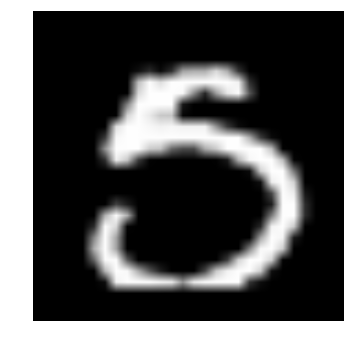

Classified as 1 with probability 0.999469


In [9]:
import random
random_num=random.randint(0, 2000)

plt.imshow(val_img[random_num], cmap='Greys_r')
plt.axis('off')
plt.show()
prob = model.predict(to4d(val_img[random_num:random_num+1]))[0]
print 'Classified as %d with probability %f' % (prob.argmax(), max(prob))

We can also evaluate the accuracy given a data iterator. 

In [10]:
print 'Validation accuracy: %f%%' % (model.score(val_iter)*100,)

Validation accuracy: 100.000000%


Even more, we can recognizes the digit written on the below box.

In [11]:
from IPython.display import HTML
import cv2
import numpy as np



def classify(img):
    img = img[len('data:image/png;base64,'):].decode('base64')
    img = cv2.imdecode(np.fromstring(img, np.uint8), -1)
    img = cv2.resize(img[:,:,3], (28,28))
    img = img.astype(np.float32).reshape((1,1,28,28))/255.0
    return model.predict(img)[0].argmax()

'''
To see the model in action, run the demo notebook at
https://github.com/dmlc/mxnet-notebooks/blob/master/python/tutorials/mnist.ipynb.
'''
HTML(filename="mnist_demo.html" )

## LeNet analyzing

Many of entry level developers want to know how CNN works, we can look into different layers of LeNet, and get the output features, to get basic understanding of LeNet and CNN.

At first , we can list all the outputs layers of the LeNet model.

If you want to get more information of the symbol in model, you can print all the imformation with:

`print (internals.tojson())`

In [12]:
internals = model.symbol.get_internals()
internals.list_outputs()

['data',
 'convolution0_weight',
 'convolution0_bias',
 'convolution0_output',
 'activation0_output',
 'pooling0_output',
 'convolution1_weight',
 'convolution1_bias',
 'convolution1_output',
 'activation1_output',
 'pooling1_output',
 'flatten0_output',
 'fullyconnected0_weight',
 'fullyconnected0_bias',
 'fullyconnected0_output',
 'activation2_output',
 'fullyconnected1_weight',
 'fullyconnected1_bias',
 'fullyconnected1_output',
 'activation3_output',
 'fullyconnected2_weight',
 'fullyconnected2_bias',
 'fullyconnected2_output',
 'softmax_label',
 'softmax_output']

The we can try to get features from different output layers for analyzing. 

Before that, let's select a new sample randomly for comming test.

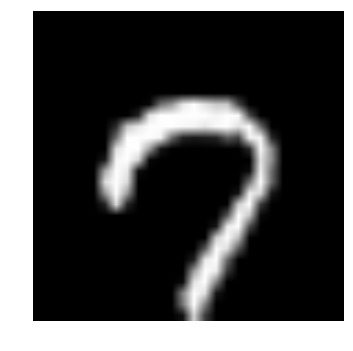

In [30]:

sample_index=random.randint(0, 2000)

analyst_sample = val_img[sample_index:sample_index+1]

plt.imshow(val_img[sample_index], cmap='Greys_r')
plt.axis('off')
plt.show()


The wen can get the features of "convolutions0_output" and display them.

Note that the first convolution layer in Lenet has 20 filters, so the "depth" of the output feature is 20. 

The fileters are `5X5` filter with `1` step, and the input image is `28*28` image, so the "width" and "length" of the output feature is `24*24` ( `28-(5-1) = 24` )

That means, the output features of "Convolutions0" is `20*24*24 Array`

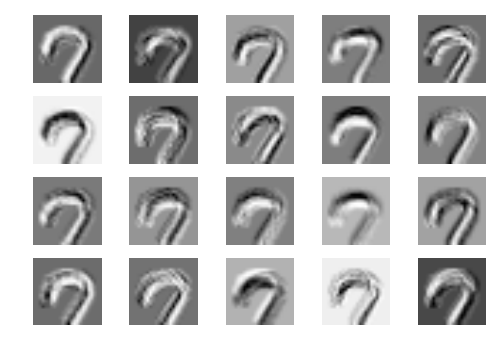

In [32]:
fea_symbol = internals["convolution0_output"]  
feature_extractor = mx.model.FeedForward(ctx=mx.gpu(), symbol=fea_symbol, numpy_batch_size=1,  
                                         arg_params=model.arg_params, aux_params=model.aux_params,  
                                         allow_extra_params=True)  

[val_feature, valdata, vallabel]= feature_extractor.predict(to4d(analyst_sample), return_data=True)


for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(val_feature[0][i], cmap='Greys_r')
    plt.axis('off')
plt.show()


With the same code, we can get the features of "activation0_output" and display them.

The shape of the features doesn't change, it is `20*24*24 Array` too.

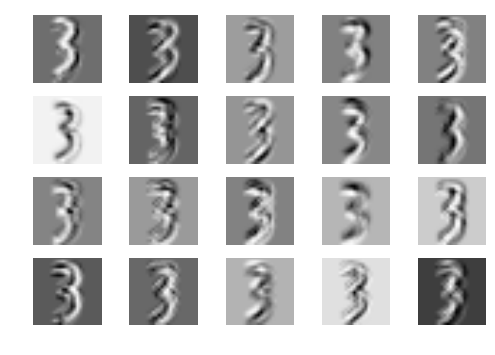

In [15]:
fea_symbol = internals["activation0_output"]  
feature_extractor = mx.model.FeedForward(ctx=mx.gpu(), symbol=fea_symbol, numpy_batch_size=1,  
                                         arg_params=model.arg_params, aux_params=model.aux_params,  
                                         allow_extra_params=True)  

[val_feature, valdata, vallabel]= feature_extractor.predict(to4d(analyst_sample), return_data=True)

for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(val_feature[0][i], cmap='Greys_r')
    plt.axis('off')
plt.show()

Then we can get the features of Pooling0 layer two, as Pooling0 is a 2X2 pooling with step 2, the new shape of output features is `20*12*12 Array`, each 2X2 area in previous output was pool as 1 feature. 24X24 "image" became 12X12 "image". 

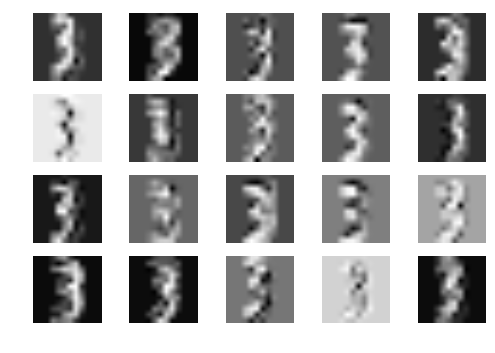

In [16]:
fea_symbol = internals["pooling0_output"]  
feature_extractor = mx.model.FeedForward(ctx=mx.gpu(), symbol=fea_symbol, numpy_batch_size=1,  
                                         arg_params=model.arg_params, aux_params=model.aux_params,  
                                         allow_extra_params=True)  

[val_feature, valdata, vallabel]= feature_extractor.predict(to4d(analyst_sample), return_data=True)


for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(val_feature[0][i], cmap='Greys_r')
    plt.axis('off')
plt.show()

With the following code we got the output feature of convolution1_output.

The input features of convolution1_output is `20*12X12`

There are 50 fileters in this layer, the filters are 5X5 filters with 1 step.

So the shape of new features is `50*8*8` (`12 - (5-1) = 8`)

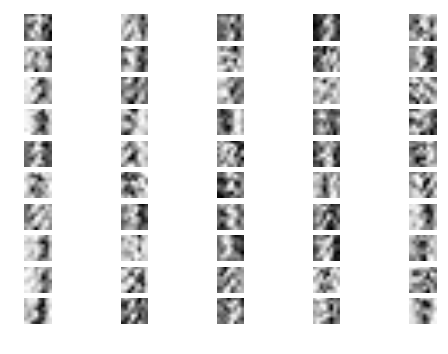

In [17]:
fea_symbol = internals["convolution1_output"]  
feature_extractor = mx.model.FeedForward(ctx=mx.gpu(), symbol=fea_symbol, numpy_batch_size=1,  
                                         arg_params=model.arg_params, aux_params=model.aux_params,  
                                         allow_extra_params=True)  

[val_feature, valdata, vallabel]= feature_extractor.predict(to4d(analyst_sample), return_data=True)


for i in range(50):
    plt.subplot(10,5,i+1)
    plt.imshow(val_feature[0][i], cmap='Greys_r')
    plt.axis('off')
plt.show()



Then the pooling1_output layer, pooling1 is 2X2 pooling with step 2, so shape of new output features is `50*4*4`

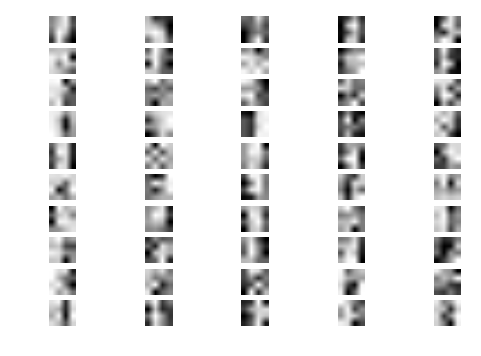

In [18]:
fea_symbol = internals["pooling1_output"]  
feature_extractor = mx.model.FeedForward(ctx=mx.gpu(), symbol=fea_symbol, numpy_batch_size=1,  
                                         arg_params=model.arg_params, aux_params=model.aux_params,  
                                         allow_extra_params=True)  

[val_feature, valdata, vallabel]= feature_extractor.predict(to4d(analyst_sample), return_data=True)


for i in range(50):
    plt.subplot(10,5,i+1)
    plt.imshow(val_feature[0][i], cmap='Greys_r')
    plt.axis('off')
plt.show()

The the flatten0 layer convert the `50*4*4` Array into a vector, length of the vector is `50*4*4=800`

To display the vector with 800 elements , we use the bar function of plt.

In fact, the bar graph of 800 vector and the 50 "images" in previous cell is the same thing, they are different shape of same data.

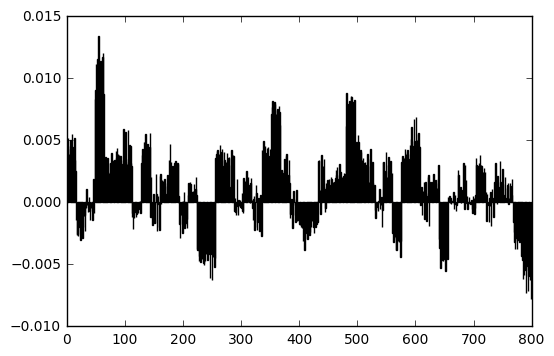

In [19]:
fea_symbol = internals["flatten0_output"]  
feature_extractor = mx.model.FeedForward(ctx=mx.gpu(), symbol=fea_symbol, numpy_batch_size=1,  
                                         arg_params=model.arg_params, aux_params=model.aux_params,  
                                         allow_extra_params=True)  

[val_feature, valdata, vallabel]= feature_extractor.predict(to4d(analyst_sample), return_data=True)

x=range(0,800)

plt.bar(x,val_feature[0])

plt.show()

With the same technique, we can display the output of `fullyconnected0_output` as a bar graph.

The `fullyconnected0_output` is fully connected with previous layer and has 500 outputs

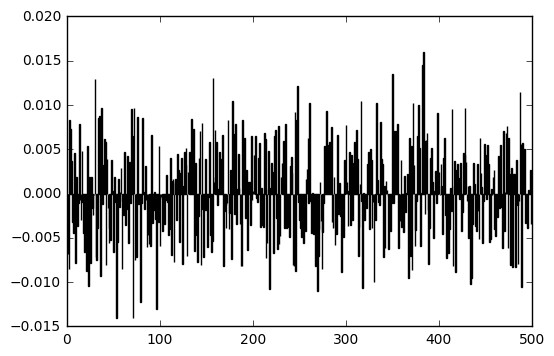

In [20]:
fea_symbol = internals["fullyconnected0_output"]  
feature_extractor = mx.model.FeedForward(ctx=mx.gpu(), symbol=fea_symbol, numpy_batch_size=1,  
                                         arg_params=model.arg_params, aux_params=model.aux_params,  
                                         allow_extra_params=True)  

[val_feature, valdata, vallabel]= feature_extractor.predict(to4d(analyst_sample), return_data=True)

x=range(0,500)

plt.bar(x,val_feature[0])

plt.show()

Then we can display the output of `fullyconnected1_output` as a bar graph.

The `fullyconnected1_output` has 10 outputs

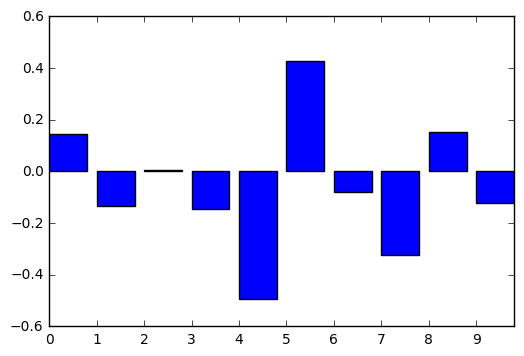

In [33]:
fea_symbol = internals["fullyconnected1_output"]  
feature_extractor = mx.model.FeedForward(ctx=mx.gpu(), symbol=fea_symbol, numpy_batch_size=1,  
                                         arg_params=model.arg_params, aux_params=model.aux_params,  
                                         allow_extra_params=True)  

[val_feature, valdata, vallabel]= feature_extractor.predict(to4d(analyst_sample), return_data=True)

x=range(0,10)
xticks=range(0,10,1)
plt.xticks(xticks)

plt.bar(x,val_feature[0])

plt.show()

`softmax_output` use softmax to caculate the possibility.

We can use the same bar graph to display the output of softmax.

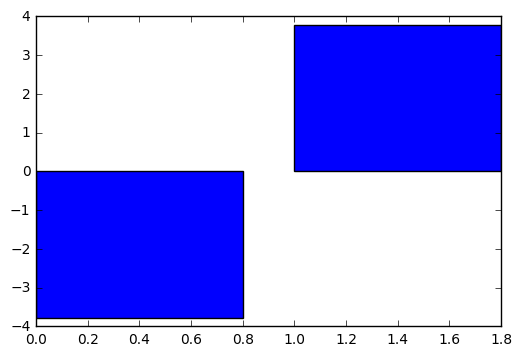

In [27]:
fea_symbol = internals["fullyconnected2_output"]  
feature_extractor = mx.model.FeedForward(ctx=mx.gpu(), symbol=fea_symbol, numpy_batch_size=1,  
                                         arg_params=model.arg_params, aux_params=model.aux_params,  
                                         allow_extra_params=True)  

[val_feature, valdata, vallabel]= feature_extractor.predict(to4d(analyst_sample), return_data=True)

val_feature

x=range(0,2)

plt.bar(x,val_feature[0])

plt.show()

Now, the number in x axis has highest bar is the digit you writen.